In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')


import nltk
import string
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as ltb
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score 

In [17]:
# import the csv files

df = pd.read_csv("E:/examen tecnico/Sentiment analysis csv/Train.csv")
test = pd.read_csv("E:/examen tecnico/Sentiment analysis csv/Test.csv")

In [4]:
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [5]:
#The dataset it's divided into two different columns, "text" that has the review 
#and "label" an int 1 or 0 that makes the review a good(1) or bad (0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


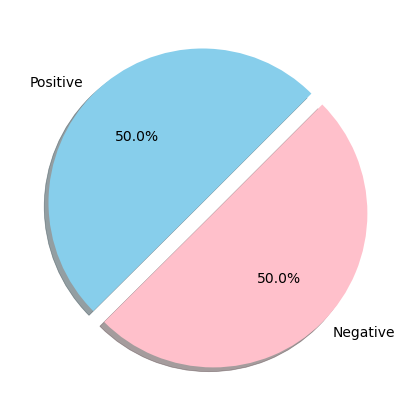

In [42]:
#it's a 50/50 distribution thing that makes better the acuracy for the NLP (natural languange processing) model
fig=plt.figure(figsize=(5,5))
colors=["skyblue",'pink']
pos=df[df['label']==1]
neg=df[df['label']==0]
ck=[pos['label'].count(),neg['label'].count()]
legpie=plt.pie(ck,labels=["Positive","Negative"],
                 autopct ='%1.1f%%', 
                 shadow = True,
                 colors = colors,
                 startangle = 45,
                 explode=(0, 0.1))

In [9]:
#as we can see the reviews have uppercase and other punctuations that will make the NLP fail, so we need to preprocess the text
df['text'].head()

0    I grew up (b. 1965) watching and loving the Th...
1    When I put this movie in my DVD player, and sa...
2    Why do people who do not know what a particula...
3    Even though I have great interest in Biblical ...
4    Im a die hard Dads Army fan and nothing will e...
Name: text, dtype: object

In [12]:
# we create a function that will clean the reviews and make them better for the NLP process
def cleaning (text):
    text = text.lower() #only lowercases
    text =  re.sub(r'@\S+', '',text)  # remove twitter handles
    text =  re.sub(r'http\S+', '',text) # remove urls
    text =  re.sub(r'pic.\S+', '',text)
    text =  re.sub(r"[^a-zA-ZáéíóúÁÉÍÓÚ']", ' ',text) # only keeps characters
    text =  re.sub(r'\s+[a-zA-ZáéíóúÁÉÍÓÚ]\s+', ' ', text+' ')  # keep words with length>1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
    text = " ".join([i for i in words if i not in stopwords])
    text= re.sub("\s[\s]+", " ",text).strip()
    text= re.sub("\s[\s]+", " ",text).strip() # remove repeated/leading/trailing spaces
    return text

In [15]:
# Lemmatization is a text pre-processing technique used in NLP models to break a word 
# down to its root meaning to identify similarities.

def lemm(data):
    wordnet = WordNetLemmatizer()
    lemmanized = []
    for i in range(len(data)):
        lemmed = []
        words = word_tokenize(data['text'].iloc[i])
        for w in words:
            lemmed.append(wordnet.lemmatize(w))
        lemmanized.append(lemmed)

    data['lemmanized'] = lemmanized
    data['text'] = data['lemmanized'].apply(' '.join)
    data=data.drop("lemmanized",axis=1)
    return data

In [19]:
# we clean all the dataset reviews using the previous function

print("cleaning the reviews...")
df["text"]=df["text"].apply(cleaning)
print("1/2...")
test["text"]=test["text"].apply(cleaning)
print("Process ended.")

cleaning the reviews...
1/2...
Process ended.


In [20]:
# now we can see that the text is completely clean for the process
df['text'].head()

0    grew watching loving thunderbirds mates school...
1    put movie dvd player sat coke chips expectatio...
2    people know particular time past like feel nee...
3    even though great interest biblical movies bor...
4    im die hard dads army fan nothing ever change ...
Name: text, dtype: object

In [21]:
# apply it to the datasets

print("Appliying the Lemmatization...")
df=lemm(df)
print("1/2...")
test=lemm(test)
print("process ended")



Appliying the Lemmatization...
1/2...
process ended


In [22]:
df.head()

,text,label
0,grew watching loving thunderbird mate school w...,0
1,put movie dvd player sat coke chip expectation...,0
2,people know particular time past like feel nee...,0
3,even though great interest biblical movie bore...,0
4,im die hard dad army fan nothing ever change g...,1


Now we need to make some changes for the traing and test data, this changes are basically make the text into numbers
so the machine learning can understand it and get trained with it.

Vectorization with TF-IDF (Term Frequency-Inverse Document Frequency) is a method in NLP that converts text into numerical form. It weighs words based on their frequency in a document and rarity in the corpus, capturing their significance.

In [23]:
tfid = TfidfVectorizer()
X_train = tfid.fit_transform(df["text"])
X_test = tfid.transform(test["text"])

# for the dependant variable is not needed since is already an int64
y_train = df["label"]
y_test = test["label"]

A text dataset that had undergone TF-IDF transformation was made less dimensional by using PCA. PCA reduced overfitting, increased data visualization, and increased computational efficiency by identifying significant patterns while removing less important information. This made it possible to train models more quickly, improve interpretability, and create a more condensed representation of the original text data.

In [24]:
svd = TruncatedSVD(n_components=50)

# use fit_transform on our standardized training features
X_train_pca = svd.fit_transform(X_train)

# use transform on our standardized test features
X_test_pca = svd.transform(X_test)

# look at the new shape of the transformed matrices
print('Training features matrix is: ', X_train_pca.shape)
print('Test features matrix is: ', X_test_pca.shape)

Training features matrix is:  (40000, 50)
Test features matrix is:  (5000, 50)


In [54]:
model = LogisticRegression()
model.fit(X_train_pca,y_train)
preds = model.predict(X_test_pca)

testD =np.array(y_test)

print("first 5 predictions: ", preds[:5])
print("first 5 real inputs: ", np.array_str(testD[:5], max_line_width=np.inf, suppress_small=True))
print("The accuracy of the predictions are: ", (accuracy_score(preds,y_test) * 100), "%" )

first 5 predictions:  [1 0 0 1 0]
first 5 real inputs:  [0 0 0 1 0]
The accuracy of the predictions are:  84.86 %
